In [119]:
import os
import numpy as np
import pandas as pd
import warnings
warnings.simplefilter(action='ignore', category=Warning)
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import glob

# Read in data
The stock data first:

In [158]:
dfs = {}

for ticker in ['BLK', 'GS', 'MS']:
    dfs[ticker] = pd.read_pickle('stock_{}.pickle'.format(ticker)).set_index('Date')

In [159]:
dfs['GS'].head()

,Close,diff_1d,diff_7d,Label
Date,,,,
2007-01-03,200.720001,NaN,NaN,0
2007-01-04,198.850006,NaN,NaN,0
2007-01-05,199.050003,-0.009316,NaN,1
2007-01-08,203.729996,0.001006,NaN,1
2007-01-09,204.080002,0.023512,NaN,1


The media data:

In [160]:
df_media = pd.read_csv('MediaAttention_Mini.csv', parse_dates=[0], index_col='Time')

In [161]:
df_media.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 366 entries, 2008-01-01 to 2008-12-31
Data columns (total 23 columns):
Morgan_Stanley_count             366 non-null int64
Goldman_Sachs_count              366 non-null int64
BlackRock_count                  366 non-null int64
positive_count                   366 non-null int64
negative_count                   366 non-null int64
Morgan_Stanley_positive_count    366 non-null int64
Morgan_Stanley_negative_count    366 non-null int64
Goldman_Sachs_positive_count     366 non-null int64
Goldman_Sachs_negative_count     366 non-null int64
BlackRock_positive_count         366 non-null int64
BlackRock_negative_count         366 non-null int64
total_msg_count                  366 non-null int64
Morgan_Stanley_frac              366 non-null float64
Goldman_Sachs_frac               366 non-null float64
BlackRock_frac                   366 non-null float64
positive_frac                    366 non-null float64
negative_frac                    366

In [173]:
df_media_long = pd.DataFrame([])
for fle in glob.glob('MediaAttentionLong*.csv'):
    dummy = pd.read_csv(fle, parse_dates=[0], index_col='Time')
    df_media_long =  pd.concat([df_media_long,dummy])
              
df_media_long = df_media_long['2007':'2012']
df_media_long = df_media_long.resample('1D').sum()
df_media_long.shape

(2192, 23)

In [163]:
for ticker in dfs:
    dfs[ticker] = dfs[ticker].merge(df_media_long, how='inner', left_index=True, right_index=True)

In [164]:
dfs['BLK'].head()

,Close,diff_1d,diff_7d,Label,Morgan_Stanley_count,Goldman_Sachs_count,BlackRock_count,positive_count,negative_count,Morgan_Stanley_positive_count,...,Goldman_Sachs_frac,BlackRock_frac,positive_frac,negative_frac,Morgan_Stanley_positive_frac,Morgan_Stanley_negative_frac,Goldman_Sachs_positive_frac,Goldman_Sachs_negative_frac,BlackRock_positive_frac,BlackRock_negative_frac
2007-01-03,155.119995,NaN,NaN,0,23,18,0,1689,1443,52,...,0.028846,0.0,2.706731,2.312500,0.083333,0.232372,0.064103,0.054487,0.0,0.0
2007-01-04,156.789993,NaN,NaN,1,24,16,0,1762,1592,77,...,0.021362,0.0,2.352470,2.125501,0.102804,0.104139,0.072096,0.017356,0.0,0.0
2007-01-05,156.750000,0.010766,NaN,0,13,16,0,2066,1773,50,...,0.024060,0.0,3.106767,2.666165,0.075188,0.058647,0.109774,0.079699,0.0,0.0
2007-01-08,159.639999,-0.000255,NaN,1,17,68,0,2308,1919,23,...,0.077273,0.0,2.622727,2.180682,0.026136,0.056818,0.245455,0.215909,0.0,0.0
2007-01-09,160.649994,0.018437,NaN,1,15,31,0,2385,2244,83,...,0.032597,0.0,2.507886,2.359621,0.087277,0.058885,0.126183,0.110410,0.0,0.0


# Model

In [165]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, recall_score, roc_auc_score, make_scorer
from sklearn.model_selection import  cross_val_score, KFold

In [166]:
model = RandomForestClassifier(n_estimators=100, max_depth=2, random_state=314, n_jobs=4)

In [170]:
for ticker in dfs:
    X = dfs[ticker].drop(['Label', 'Close'], axis=1)
    y = dfs[ticker].loc[:,'Label']
    scores = cross_val_score(model, X.fillna(-1), y.fillna(-1), 
                             scoring=make_scorer(accuracy_score), 
                             cv=KFold(5, shuffle=True, random_state=314), 
                             n_jobs=1
                            )
    print('{} prediction performance in accuracy = {:.3f}+-{:.3f}'.format(ticker,
                                                                          np.mean(scores),
                                                                          np.std(scores)
                                                                         ))

BLK prediction performance in accuracy = 0.514+-0.015
GS prediction performance in accuracy = 0.514+-0.033
MS prediction performance in accuracy = 0.512+-0.017


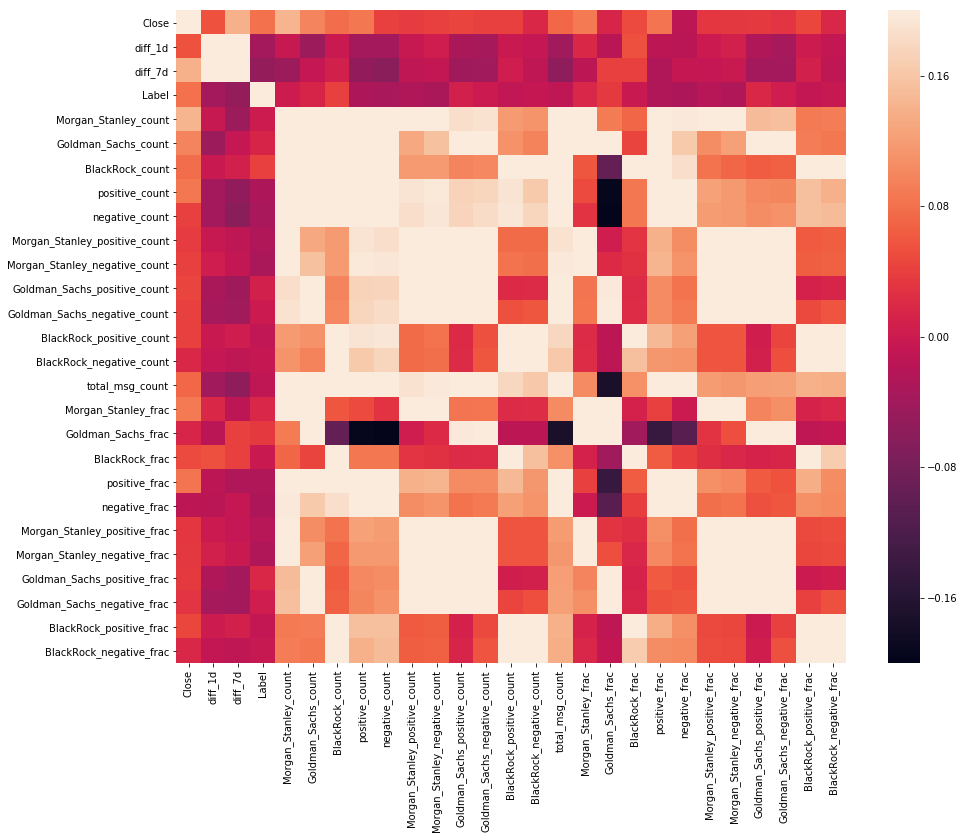

In [168]:
plt.figure(figsize=(15,12))
sns.heatmap(dfs['BLK'].corr(), vmin=-0.2, vmax=0.2)

In [174]:
# model all together
df = pd.concat(list(dfs.values()), axis=0)
X = df.drop(['Label', 'Close'], axis=1).fillna(-1)
y = df.loc[:,'Label']
scores = cross_val_score(model, X.fillna(-1), y.fillna(-1), 
                         scoring=make_scorer(accuracy_score), 
                         cv=KFold(10, shuffle=True, random_state=314), 
                         n_jobs=1
                        )
print('{} prediction performance in accuracy = {:.3f}+-{:.3f}'.format('ALL',
                                                                      np.mean(scores),
                                                                      np.std(scores)
                                                                     ))

ALL prediction performance in accuracy = 0.540+-0.015
